# Transfer Learning InceptionV3 Raw Data i224 b32 e50 ft2

## Details 

In this notebook the InceptionV3 model will be trained on the Raw Dataset. 

Image size is 224, Batch size is 32, Epochs is 50, model is trained then finetuned again on the same dataset.


### Importing Libraries

In [25]:
import os
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    BatchNormalization,
    Activation,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.applications import (
    InceptionV3,
)
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [27]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from pathlib import Path

In [28]:
# Global Variables
MODEL_NAME = "tl_inceptionv3_raw_i224_b32_e50"

NUM_CLASSES = 38
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

# Get the base directory
BASE_DIR = Path.cwd().parent.parent

now = datetime.now()

### Importing Dataset

#### Dataset Preparation

In [29]:
# Define paths
TRAIN_DIR = BASE_DIR / "datasets" / "Plant_Disease_Dataset" / "train"
VALID_DIR = BASE_DIR / "datasets" / "Plant_Disease_Dataset" / "valid"
SAMPLE_IMAGE = (
    BASE_DIR / "datasets" / "cropped_plant_village_dataset" / "sample_image.JPG"
)

print("Train Directory:", TRAIN_DIR)
print("Valid Directory:", VALID_DIR)
print("Sample Image Path:", SAMPLE_IMAGE)

Train Directory: /home/sam5io/sam_engineerings/AgroDiagnoseAI/datasets/Plant_Disease_Dataset/train
Valid Directory: /home/sam5io/sam_engineerings/AgroDiagnoseAI/datasets/Plant_Disease_Dataset/valid
Sample Image Path: /home/sam5io/sam_engineerings/AgroDiagnoseAI/datasets/cropped_plant_village_dataset/sample_image.JPG


##### Training Set

In [30]:
training_set = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 70295 files belonging to 38 classes.


##### Validation Set

In [31]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [32]:
test_set = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


#### Dataset Details

In [33]:
# Function to count images in each class
def count_images_in_classes(dataset_dir):
    """
    Counts the number of images in each class within a dataset directory.

    Args:
        dataset_dir (str): The path to the dataset directory.

    Returns:
        dict: A dictionary where the keys are the class names and the values are the number of images in each class.
    """
    class_counts = {}
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts


# Count images in training and validation sets
train_class_counts = count_images_in_classes(TRAIN_DIR)
valid_class_counts = count_images_in_classes(VALID_DIR)

# Create a DataFrame for better visualization
df = pd.DataFrame(
    {
        "Class": list(train_class_counts.keys()),
        "Training Images": list(train_class_counts.values()),
        "Validation Images": 
            list(valid_class_counts.values())
        # [
            # valid_class_counts.get(cls, 0) for cls in train_class_counts.keys()
        # ],
    }
).sort_values(by="Class", ascending=True)

In [34]:
# Display the DataFrame
print(df)

                                                Class  Training Images  \
29                                 Apple___Apple_scab             2016   
34                                  Apple___Black_rot             1987   
28                           Apple___Cedar_apple_rust             1760   
30                                    Apple___healthy             2008   
31                                Blueberry___healthy             1816   
0            Cherry_(including_sour)___Powdery_mildew             1683   
9                   Cherry_(including_sour)___healthy             1826   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...             1642   
13                        Corn_(maize)___Common_rust_             1907   
19                Corn_(maize)___Northern_Leaf_Blight             1908   
16                             Corn_(maize)___healthy             1859   
3                                   Grape___Black_rot             1888   
15                       Grape___Esca_

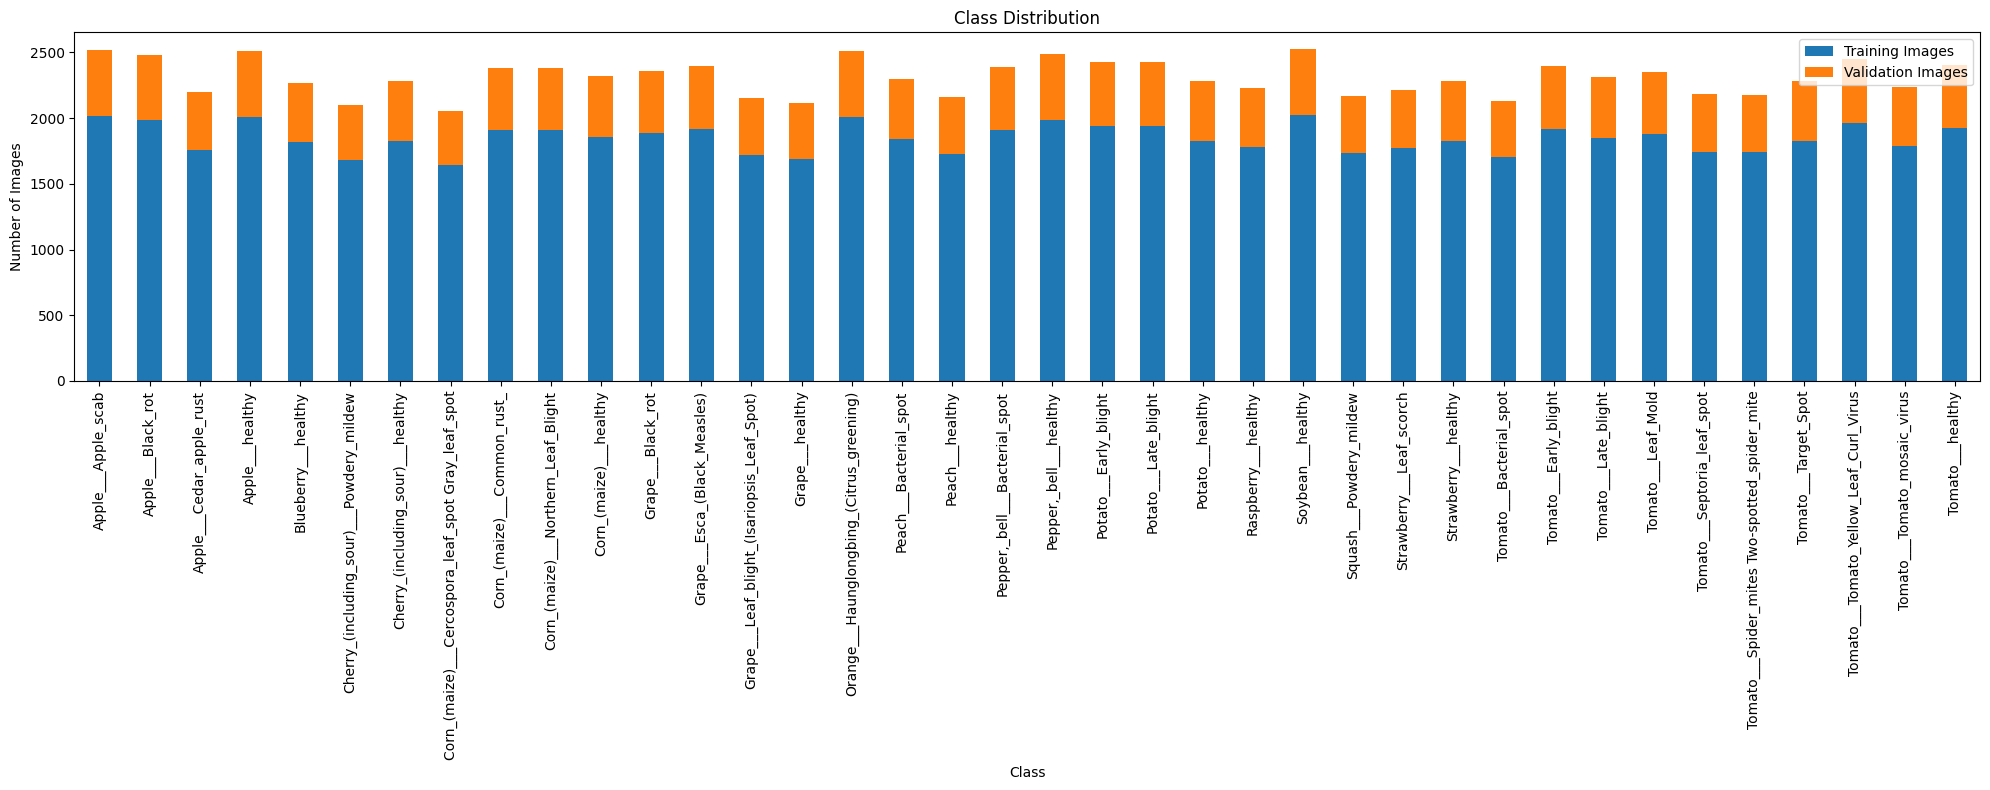

In [35]:
# Plot the class distribution with adjustments for readability
df.plot(
    x="Class", kind="bar", stacked=True, figsize=(20, 8), title="Class Distribution"
)
plt.ylabel("Number of Images")
plt.xlabel("Class")

# Rotate x-ticks for better readability
plt.xticks(rotation=90, ha="center")

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Function to visualize one image per class
def visualize_sample_images(dataset_dir):
    """
    Visualizes one sample image per class in the dataset directory.

    Args:
        dataset_dir (str): The path to the dataset directory.

    Displays a grid of images, with one image per class, using matplotlib.
    """
    class_names = os.listdir(dataset_dir)
    class_names.sort()  # Sort for consistent order

    # Calculate the number of rows and columns for the subplot grid
    num_classes = len(class_names)
    num_cols = 5  # You can adjust this number
    num_rows = math.ceil(num_classes / num_cols)

    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    for i, class_name in enumerate(class_names, start=1):
        class_path = os.path.join(dataset_dir, class_name)
        image_path = os.path.join(
            class_path, os.listdir(class_path)[0]
        )  # Get the first image in the class
        img = plt.imread(image_path)

        plt.subplot(num_rows, num_cols, i)  # Adjust grid size dynamically
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

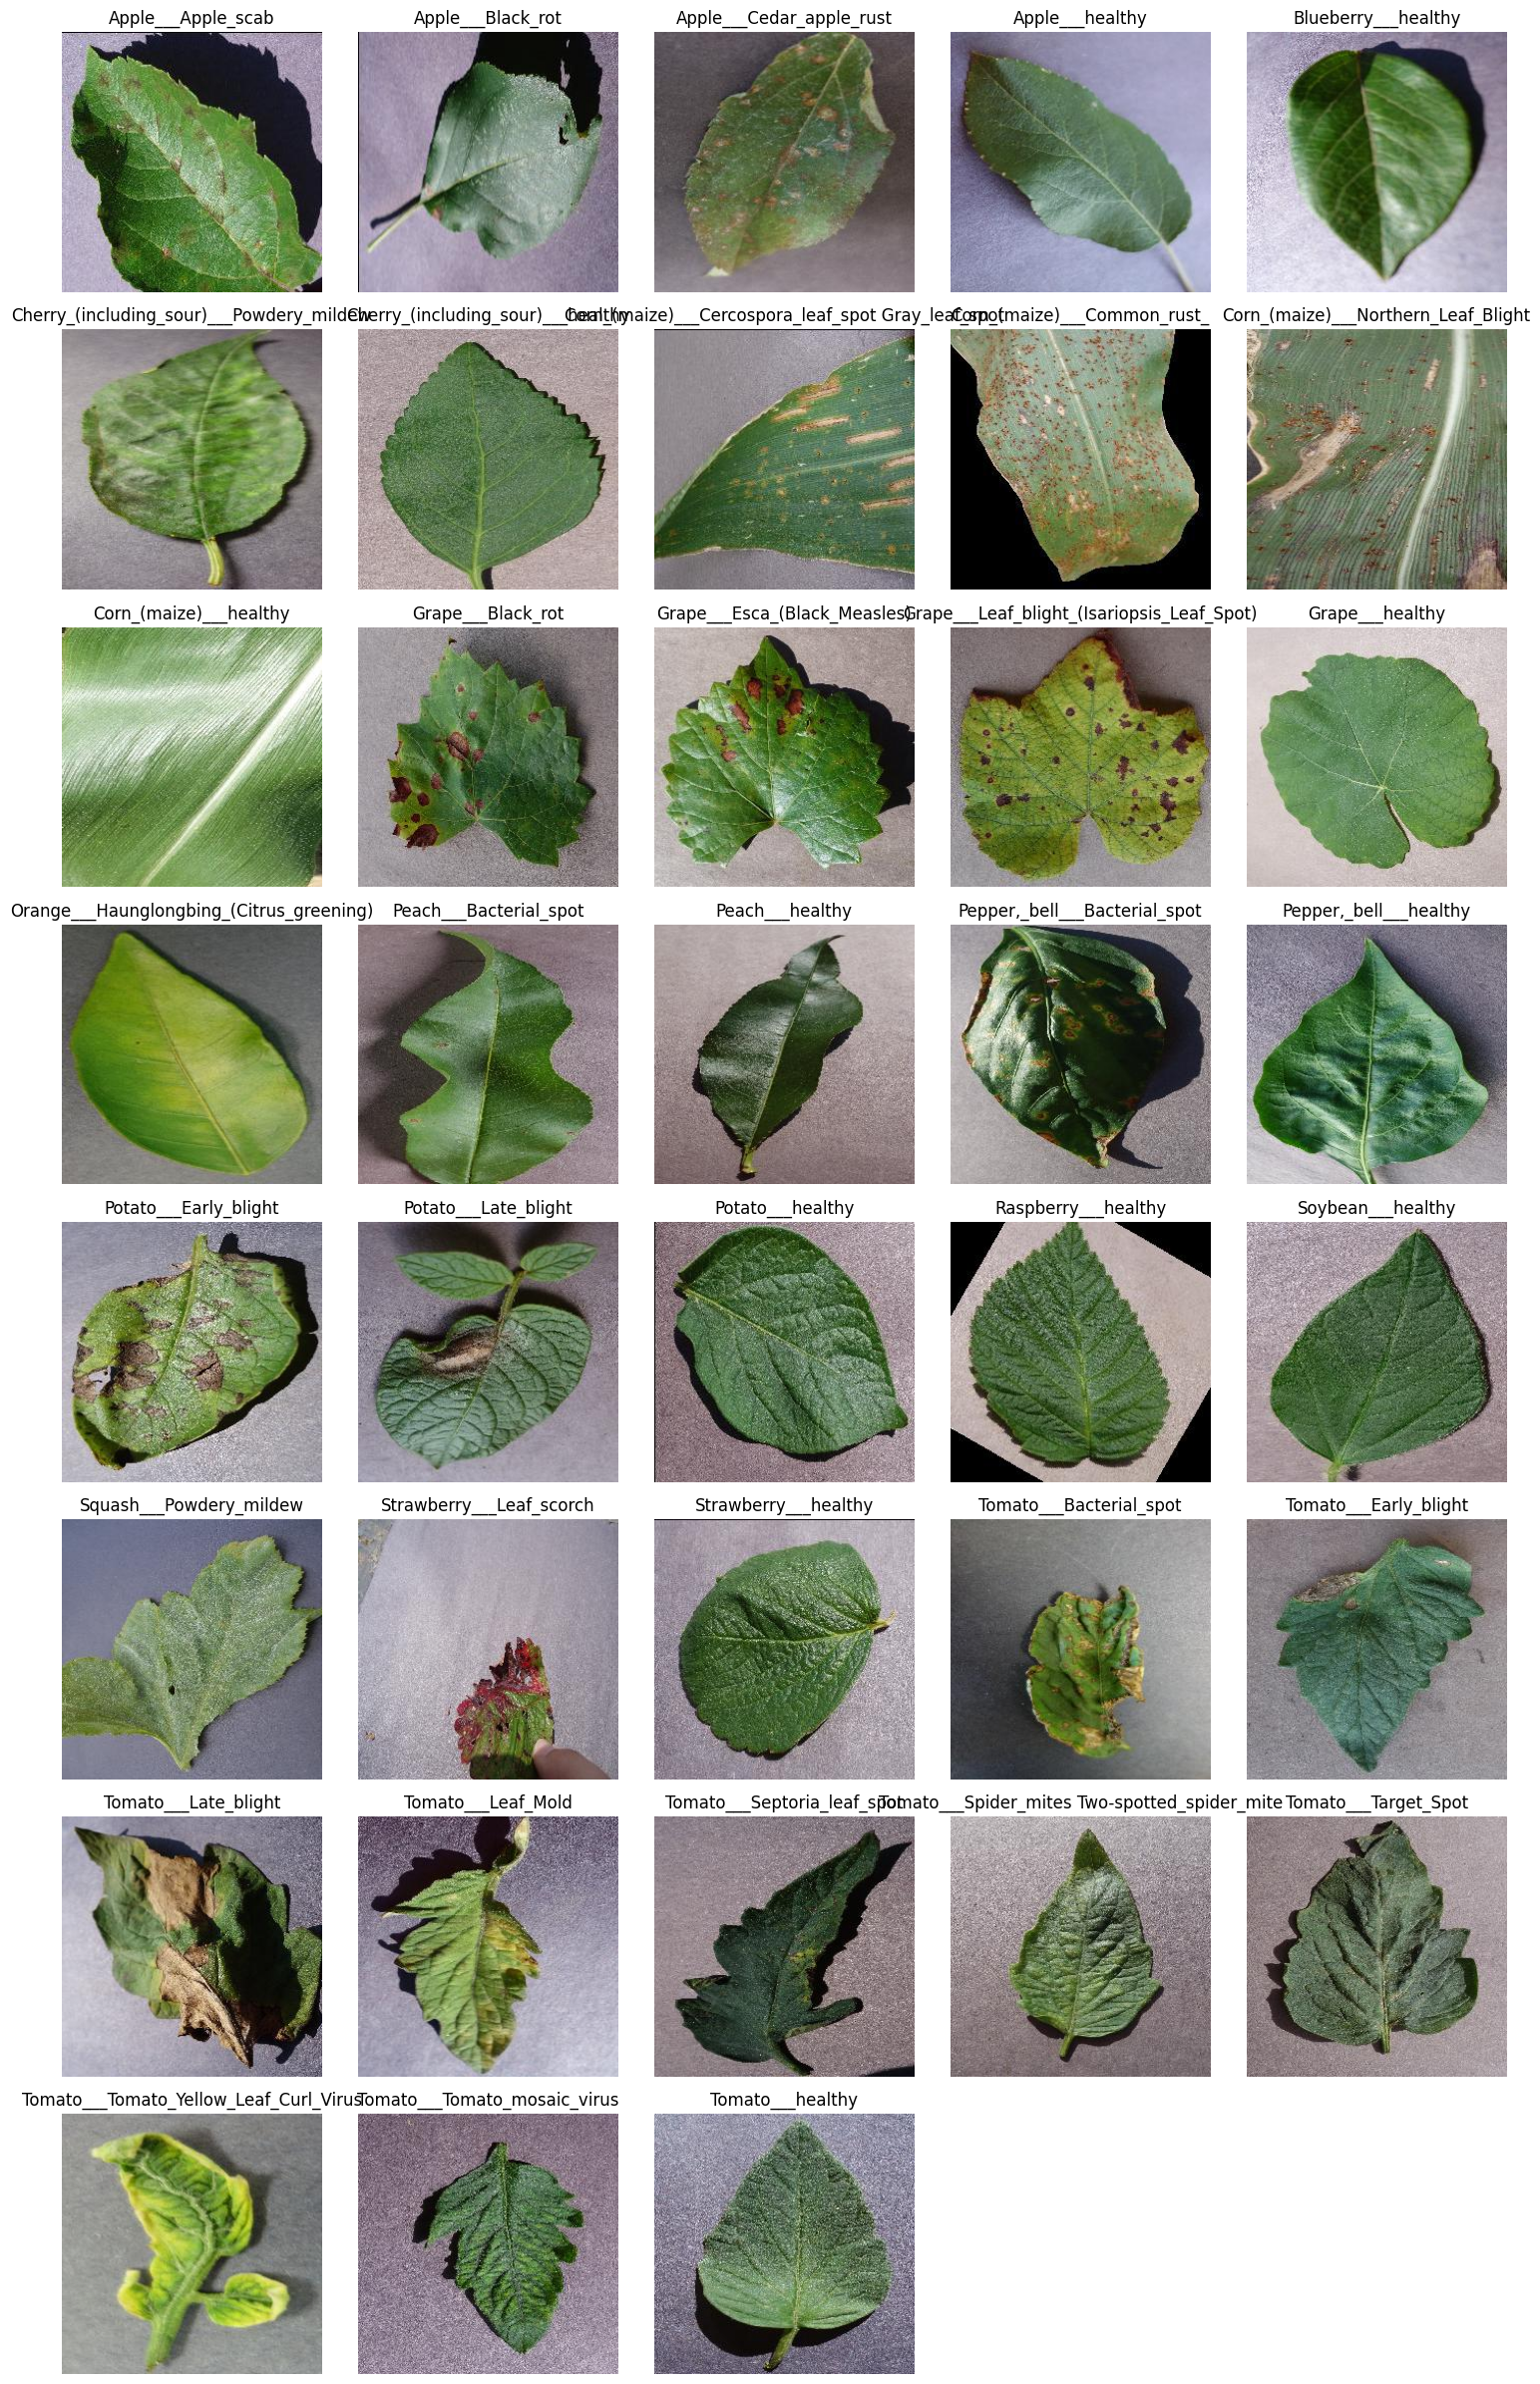

In [37]:
# Visualize sample images from training set
visualize_sample_images(TRAIN_DIR)

### Image Preprocessing

#### Normalization

In [38]:
normalize = tf.keras.layers.Rescaling(1.0 / 255)

# Apply normalization on both Training and Validation set
normalized_training_set = training_set.map(lambda x, y: (normalize(x), y))
normalized_validation_set = validation_set.map(lambda x, y: (normalize(x), y))
normalized_test_set = test_set.map(lambda x, y: (normalize(x), y))

#### Image Augmentation

In [39]:
# Apply augmentation to the training set
augmented_training_set = normalized_training_set

#### Image Enhancement (not implemented)

In [40]:
# Image Enhancements have not strongly proven to increase the accuracy

### Training Model

#### Building Model

In [41]:
# Define the number of classes in your project (38 classes)
num_classes = 38

# Load InceptionV3 model pre-trained on ImageNet without the top (classification) layer
base_model = InceptionV3(
    weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Freeze the base model (don't update weights during training)
base_model.trainable = False

In [42]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)  # Reduce spatial dimensions
x = BatchNormalization()(x)  # Normalize features to improve training stability
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.4)(x)  # Dropout for regularization
x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Add a smaller dense layer for hierarchical learning
x = Activation("relu")(x)
x = Dropout(0.25)(x)  # Another dropout layer with lower rate

predictions = Dense(num_classes, activation="softmax")(x)  # Output layer

In [43]:
# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

#### Setting Up Callbacks for Early Stopping and Model Checkpointing

In [44]:
# Define the callbacks
checkpoint = ModelCheckpoint(
    filepath=f"../models/checkpoints/{MODEL_NAME}_best_weights_{now.strftime("%Y_%m_%d_%I_%M_%S_%p")}.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6,
)

callbacks_list = [checkpoint, early_stopping, lr_scheduler]

#### Compiling Model

In [45]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

#### Training Model

In [46]:
# Get the number of samples in the training and validation datasets
# train_samples = len(training_set)
# validation_samples = len(
#     validation_set
# )

train_samples = sum([len(files) for _, _, files in os.walk(TRAIN_DIR)])
validation_samples = sum([len(files) for _, _, files in os.walk(VALID_DIR)])

print("train_samples:", train_samples)
print("validation_samples:", validation_samples)

# Calculate steps per epoch and validation steps
steps_per_epoch = (train_samples + (BATCH_SIZE - 1)) // BATCH_SIZE
validation_steps = (validation_samples + (BATCH_SIZE - 1)) // BATCH_SIZE

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

# Compute class weights to balance the dataset
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(validation_set.class_names),
    y=validation_set.class_names,
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

train_samples: 70295
validation_samples: 17572
steps_per_epoch: 2197
validation_steps: 550
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0), 20: np.float64(1.0), 21: np.float64(1.0), 22: np.float64(1.0), 23: np.float64(1.0), 24: np.float64(1.0), 25: np.float64(1.0), 26: np.float64(1.0), 27: np.float64(1.0), 28: np.float64(1.0), 29: np.float64(1.0), 30: np.float64(1.0), 31: np.float64(1.0), 32: np.float64(1.0), 33: np.float64(1.0), 34: np.float64(1.0), 35: np.float64(1.0), 36: np.float64(1.0), 37: np.float64(1.0)}


In [47]:
# Train the model
training_history = model.fit(
    augmented_training_set.repeat(),
    epochs=EPOCHS,
    validation_data=normalized_validation_set.repeat(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/50


I0000 00:00:1738225314.455859    6206 service.cc:148] XLA service 0x7f01b0002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738225314.463842    6206 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1738225317.713965    6206 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2197 ━━━━━━━━━━━━━━━━━━━━ 12:24:21 20s/step - accuracy: 0.0312 - loss: 4.5726

I0000 00:00:1738225328.485419    6206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5161 - loss: 2.1401
Epoch 1: val_accuracy improved from -inf to 0.88277, saving model to ../models/checkpoints/tl_inceptionv3_raw_i224_b32_e50_best_weights_2025_01_30_08_21_32_AM.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 155s 62ms/step - accuracy: 0.5162 - loss: 2.1398 - val_accuracy: 0.8828 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 2/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8346 - loss: 0.8341
Epoch 2: val_accuracy improved from 0.88277 to 0.91572, saving model to ../models/checkpoints/tl_inceptionv3_raw_i224_b32_e50_best_weights_2025_01_30_08_21_32_AM.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - accuracy: 0.8346 - loss: 0.8341 - val_accuracy: 0.9157 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 3/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8751 - loss: 0.6681
Epoch 3: val_accuracy improved from 0.91572 to 0.92699, saving model to ../models/checkpoints/tl_inceptionv3_ra

In [48]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze all layers except the last 20
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Continue training with fine-tuning
fine_tuning_history = model.fit(
    augmented_training_set.repeat(),
    epochs=20,  # Additional fine-tuning epochs
    validation_data=normalized_validation_set.repeat(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9117 - loss: 0.3047
Epoch 1: val_accuracy did not improve from 0.96301
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 190s 72ms/step - accuracy: 0.9118 - loss: 0.3047 - val_accuracy: 0.9526 - val_loss: 0.1814 - learning_rate: 1.0000e-05
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9627 - loss: 0.1392
Epoch 2: val_accuracy did not improve from 0.96301
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 133s 60ms/step - accuracy: 0.9627 - loss: 0.1392 - val_accuracy: 0.9597 - val_loss: 0.1535 - learning_rate: 1.0000e-05
Epoch 3/20
2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9747 - loss: 0.1045
Epoch 3: val_accuracy improved from 0.96301 to 0.96477, saving model to ../models/checkpoints/tl_inceptionv3_raw_i224_b32_e50_best_weights_2025_01_30_08_21_32_AM.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 136s 62ms/step - accuracy: 0.9747 - loss: 0.1045 - val_accuracy: 0.9648 - val_loss: 0.1384 - learning_rate: 1.0000e-05
Epoch 4/20
21

#### Evaluating Model

In [49]:
# Training set Accuracy
train_loss, train_acc = model.evaluate(augmented_training_set)
print("Training accuracy:", train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - accuracy: 1.0000 - loss: 0.0181
Training accuracy: 1.0


In [50]:
# Validation set Accuracy
val_loss, val_acc = model.evaluate(normalized_validation_set)
print("Validation accuracy:", val_acc)

550/550 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9802 - loss: 0.0836
Validation accuracy: 0.9805940985679626


#### Saving Model

In [51]:
MODEL_SAVE_DIR = (
    BASE_DIR / "models" / f"{MODEL_NAME}_{now.strftime("%Y_%m_%d_%I_%M_%S_%p")}.keras"
)

model.save(MODEL_SAVE_DIR)

In [52]:
# Save the training history
TRAIN_HIS_DIR = BASE_DIR / "training_histories" / f"training_history_{MODEL_NAME}_{now.strftime("%Y_%m_%d_%I_%M_%S_%p")}.json"
FINE_TRAIN_HIS_DIR = BASE_DIR / "training_histories" / f"fine_tunning_training_history_{MODEL_NAME}_{now.strftime("%Y_%m_%d_%I_%M_%S_%p")}.json"
with open(
    TRAIN_HIS_DIR,
    "w",
) as f:
    json.dump(training_history.history, f)

with open(
    FINE_TRAIN_HIS_DIR,
    "w",
) as f:
    json.dump(fine_tuning_history.history, f)

#### Model Details

##### Model Architecture

In [53]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_96[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_97[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_98[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_99[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 39,740,436 (151.60 MB)

 Trainable params: 8,368,614 (31.92 MB)

 Non-trainable params: 14,634,592 (55.83 MB)

 Optimizer params: 16,737,230 (63.85 MB)

##### Model Performance Metrics

In [54]:
# Get true labels
y_true = np.concatenate([y.numpy() for _, y in test_set], axis=0)

if y_true.ndim > 1:  # If it's one-hot encoded
    y_true = np.argmax(y_true, axis=1)

print(f"y_true shape: {y_true.shape}")

y_true shape: (17572,)


In [55]:
# Predict labels using the trained model
y_pred = model.predict(normalized_test_set)

if y_pred.ndim > 1:  # If it's one-hot encoded or probabilities
    y_pred = np.argmax(y_pred, axis=1)

print(f"y_pred shape: {y_pred.shape}")

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 239s 13ms/step
y_pred shape: (17572,)


In [56]:
# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_set.class_names)

print("Classification Report:")
print(report)

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       0.99      1.00      0.99       440
                                   Apple___healthy       0.99      0.99      0.99       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.90      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight      

##### Model Confusion Matrix

In [57]:
def plot_confusion_matrix_heatmap(model, test_set, class_names):
    """
    Plots the confusion matrix as a heatmap for a given model and validation dataset.
    Uses human-readable class names for display.

    Parameters:
        model: Trained model.
        test_set: Test dataset (normalized).
        class_names: List of class names.
    """
    # Get true labels and predictions
    true_labels = np.concatenate([y for x, y in test_set], axis=0)
    predicted_probs = model.predict(test_set)

    # If true_labels are one-hot encoded, convert them to class indices
    if true_labels.ndim > 1:  # Check if one-hot encoded
        true_labels = np.argmax(true_labels, axis=1)

    # Convert predicted probabilities to class indices
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(40, 40))
    sns.heatmap(
        cm,
        annot=True,
        annot_kws={"size": 10},
        cmap="magma",
        xticklabels=class_names,
        yticklabels=class_names,
    )

    plt.xlabel("Predicted Class", fontsize=20)
    plt.ylabel("Actual Class", fontsize=20)
    plt.title("Plant Disease Prediction Confusion Matrix", fontsize=25)
    plt.show()

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 219s 12ms/step


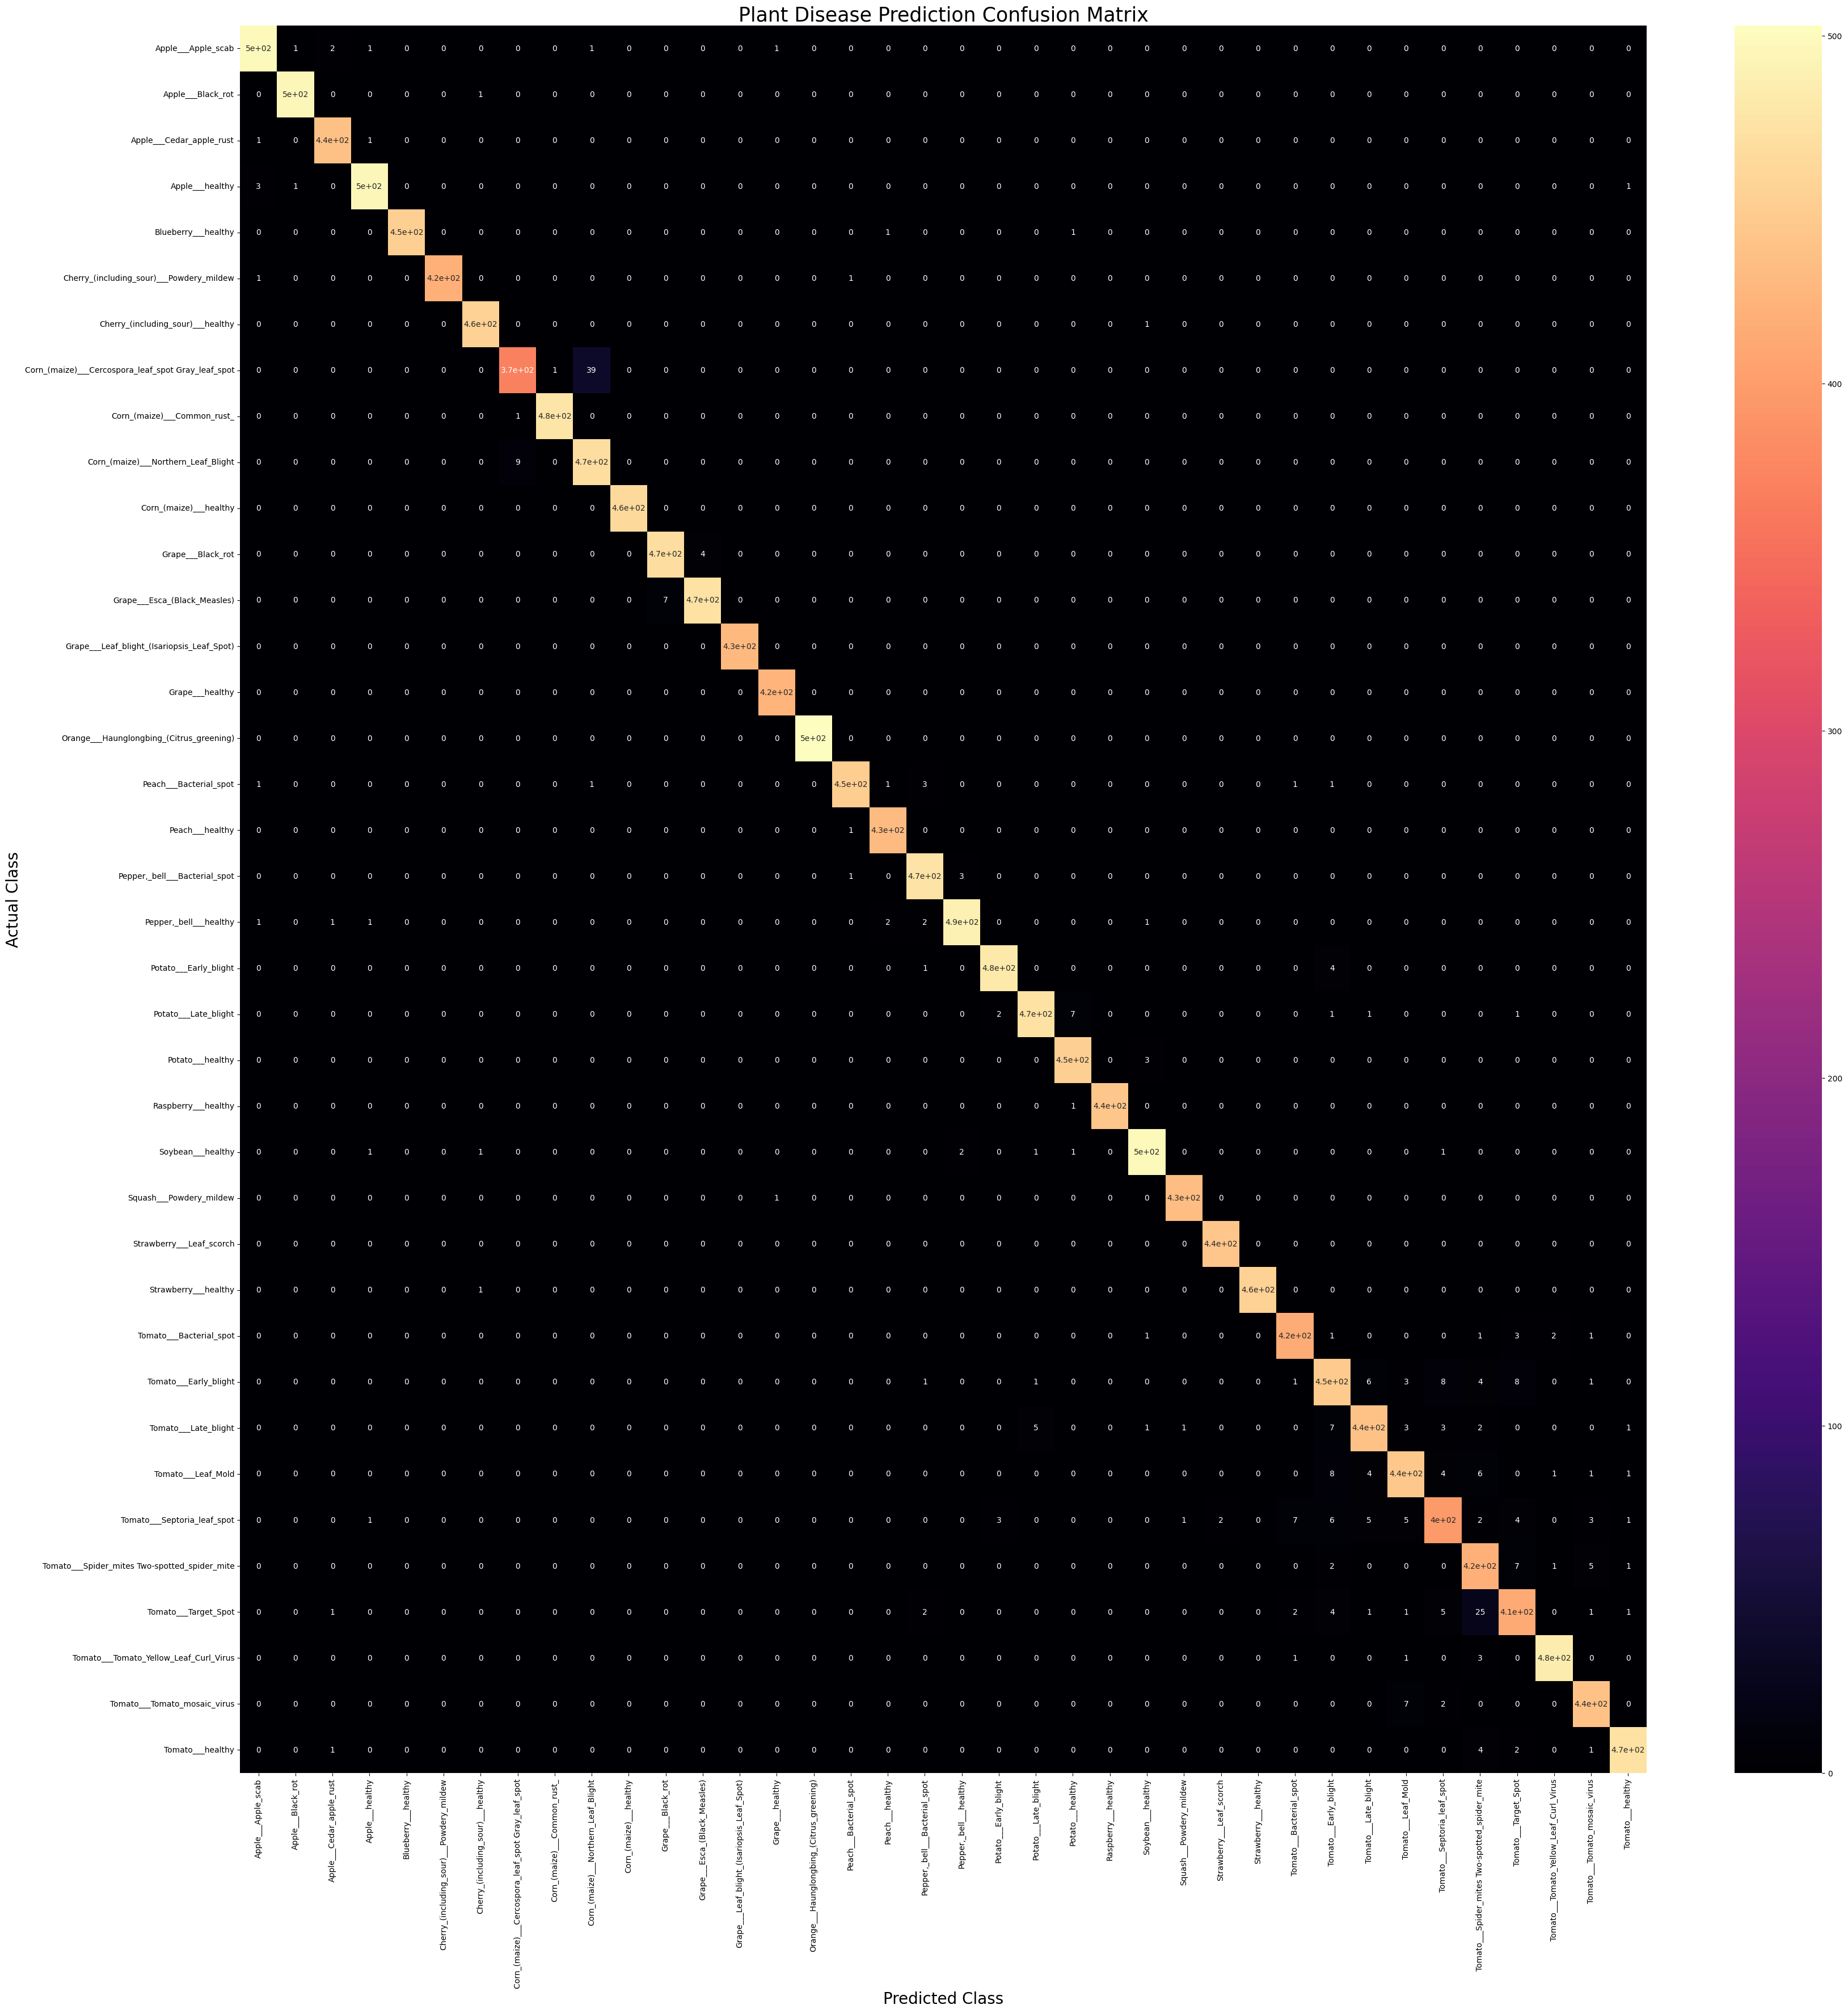

In [58]:
plot_confusion_matrix_heatmap(model, normalized_test_set, test_set.class_names)

##### Train | Vaild Accuracy & Loss graph

In [59]:
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss graphs.

    Parameters:
        history: The History object returned by model.fit().
    """
    # Extract metrics
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

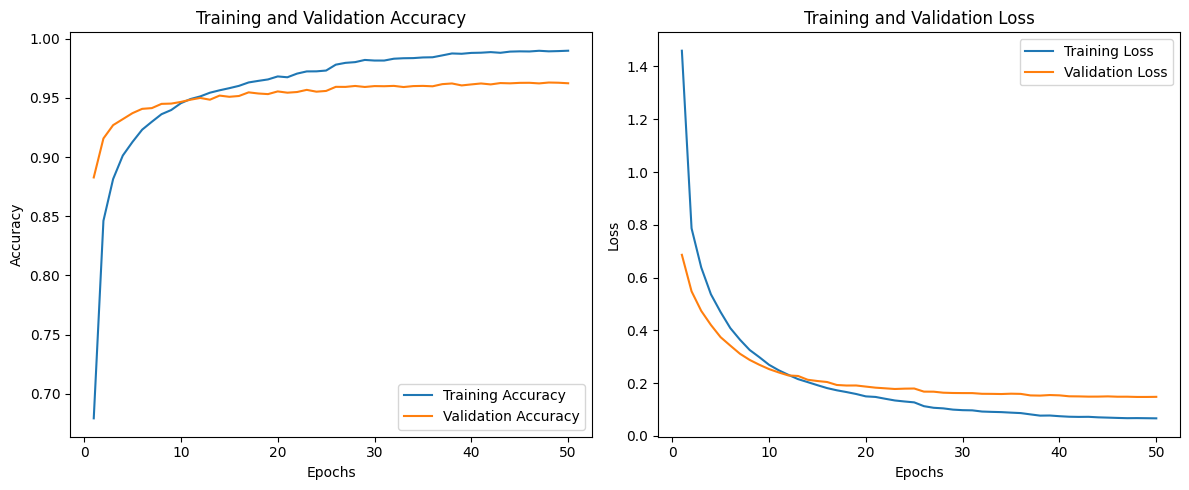

: 

In [60]:
# Plot the graphs
plot_training_history(training_history)

## Conclusion